
# Import Packages

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

In [2]:
sys.path.append(os.path.abspath(os.path.join('../../..')))
from bayesflow.forward_inference import Prior, Simulator, GenerativeModel
from bayesflow.networks import InvertibleNetwork
from bayesflow.amortized_inference import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

/home/leo/Workspace/BayesFlow/bayesflow/trainers.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Introduction
<br>
In this tutorial, we will look at a simple linear ODE system:

<br><br>
$$
\frac{du}{dt} = a u + b v \\
\frac{dv}{dt} = c u + d v  
$$
<br><br>


with the boundary conditions:

<br><br>
$$
u(t=0) = u_0 \\
v(t=0) = v_0
$$
<br><br>

Given the solutions $u(t)$ and $v(t)$, we want to use BayesFlow to predict the parameters $a$, $b$, $c$ and $d$ of the ODE equations as well as the boundary conditions $u_0$ and $v_0$.  


# Analytical Solution

The advantage of such a simple ODE system is, that the analytical solutions for $u$ and $v$ are known:

<br><br>
$$
\begin{pmatrix}
    u \\
    v
\end{pmatrix}
= C_1 e^{\lambda_1 t} \vec{v_1} + C_2 e^{\lambda_2 t} \vec{v_2} = 
\begin{bmatrix}
    \vec{v_1} & \vec{v_2}
\end{bmatrix}
\begin{pmatrix}
    C_1 e^{\lambda_1 t} \\
    C_2 e^{\lambda_2 t}
\end{pmatrix}
$$
<br><br>

where $\lambda_1$ and $\lambda_2$ are eigenvalues and $\vec{v_1}$ and $\vec{v_2}$ are eigenvectors of the matrix:

<br><br>
$$
A=
\begin{pmatrix}
    a & b \\
    c & d \\
\end{pmatrix}
$$
<br><br>

$\begin{bmatrix} \vec{v_1} & \vec{v_2} \end{bmatrix}$ is the matrix, that has the eigenvectors $\vec{v_1}$ and $\vec{v_2}$ as its column vectors. 

<br><br>
The constants $C_1$ and $C_2$ can be computed from the boundary condition:

<br><br>
$$
\begin{pmatrix}
    C_1 \\
    C_2
\end{pmatrix}
=
\begin{bmatrix}
    \vec{v_1} & \vec{v_2}
\end{bmatrix}^{-1}
\begin{pmatrix}
    u_0 \\
    v_0
\end{pmatrix}
$$

# Stability of Solutions

The solution $u$ and $v$ will be of the form:

<br><br>
$$
u = v_{11} C_1 e^{\lambda_1 t} + v_{21} C_2 e^{\lambda_2 t} \\
v = v_{12} C_1 e^{\lambda_1 t} + v_{22} C_2 e^{\lambda_2 t}
$$
<br><br>

By separating the real and complex part of the eigenvalues $\lambda_i = \gamma + i \omega$ we see: the real part affects if a solution will be exponential increasing/decreasing or stay constant, whereas the complex part will determine the oscillation behaviour. 

<br><br>
$$
u = v_{11} C_1 e^{\gamma_1 t} \left[ cos(\omega_1 t) + i sin(\omega_1 t) \right] + v_{21} C_2 e^{\gamma_2 t} \left[ cos(\omega_2 t) + i sin(\omega_2 t) \right] \\
v = v_{12} C_1 e^{\gamma_1 t} \left[ cos(\omega_1 t) + i sin(\omega_1 t) \right] + v_{22} C_2 e^{\gamma_2 t} \left[  cos(\omega_2 t) + i sin(\omega_2 t) \right]
$$
<br><br>

We will apply rejection sampling to only consider stable solutions, in other words solution that fulfill the condition $\gamma_1 \leq 0$ and $\gamma_2 \leq 0$.  

 # Generate Simulation Data with Rejection Sampling
 
We have to generate some simulation data to train our BayesFlow. The first step is to randomly draw combinations of $a$, $b$, $c$, $d$, $u_0$ and $v_0$ from a uniform prior distribution. By computing the eigenvalues, we can reject prior samples preemptively, that will lead to unstable solutions. Additionally, we estimate the prior means and standard deviations for normalization later.  

In [3]:
def model_prior():
    """Generates random draws from uniform pior with rejection sampling"""
    
    while True:
        # generate sample
        samples = np.random.uniform(low=-10, high=10, size=6)
        
        # reject, if solution not stable
        A = samples[:4].reshape((2, 2))
        eigenvalues, _ = np.linalg.eig(A)
        if eigenvalues[0].real <= 0 and eigenvalues[1].real <= 0:
            break
            
    return samples   

In [4]:
prior = Prior(prior_fun=model_prior, param_names=[r'$a$', r'$b$', r'$c$', r'$d$', r'$u_0$', r'$v_0$']) 
prior_means, prior_stds = prior.estimate_means_and_stds()

The next step is to generate simulation data from the prior samples by defining a simulator:

In [5]:
def linear_ode_solver(params, t):
    """Solves the linear ODE system analytically for given time points t and prior parameter samples"""
    
    # unpack params
    A = params[:4].reshape((2, 2))
    boundaries = params[-2:]
    
    # solve for u and v
    eigenvalues, eigenvectors = np.linalg.eig(A)
    C = np.linalg.inv(eigenvectors) @ boundaries
    solution = eigenvectors @ np.array([C[0] * np.exp(eigenvalues[0] * t), C[1] * np.exp(eigenvalues[1] * t)])
    
    return solution.T

In [6]:
time_points = np.linspace(0, 3, num=64)
simulator = Simulator(simulator_fun=partial(linear_ode_solver, t=time_points))

Finally, we will wrap the prior and simulator into a generative model for simuation data generation:

In [7]:
model = GenerativeModel(prior, simulator, name='linear_ODE_generator')

INFO:root:Performing 2 pilot runs with the linear_ODE_generator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 64, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


As a sanity check, we will sample 1000 prior combinations and visualize the joint priors in bivariate plots. Note that we have applied rejection sampling. Therefore, certain combinations of $a$, $b$, $c$, $d$ will always be rejected, because they will produce unstable solutions.  

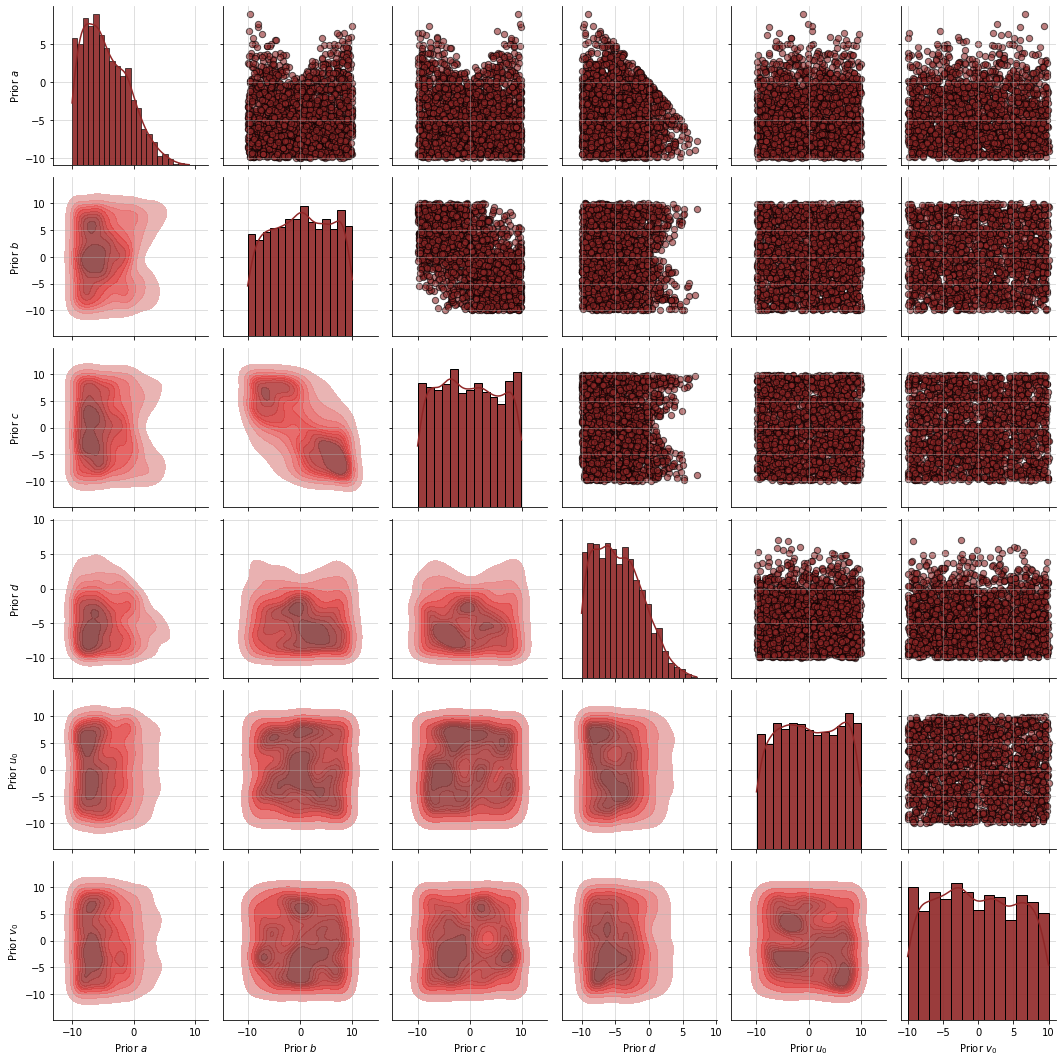

In [8]:
fig = prior.plot_prior2d()

Additionally, we can visualize the simulation data:

/home/leo/.local/share/virtualenvs/BayesFlow-sDCF3KYj/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


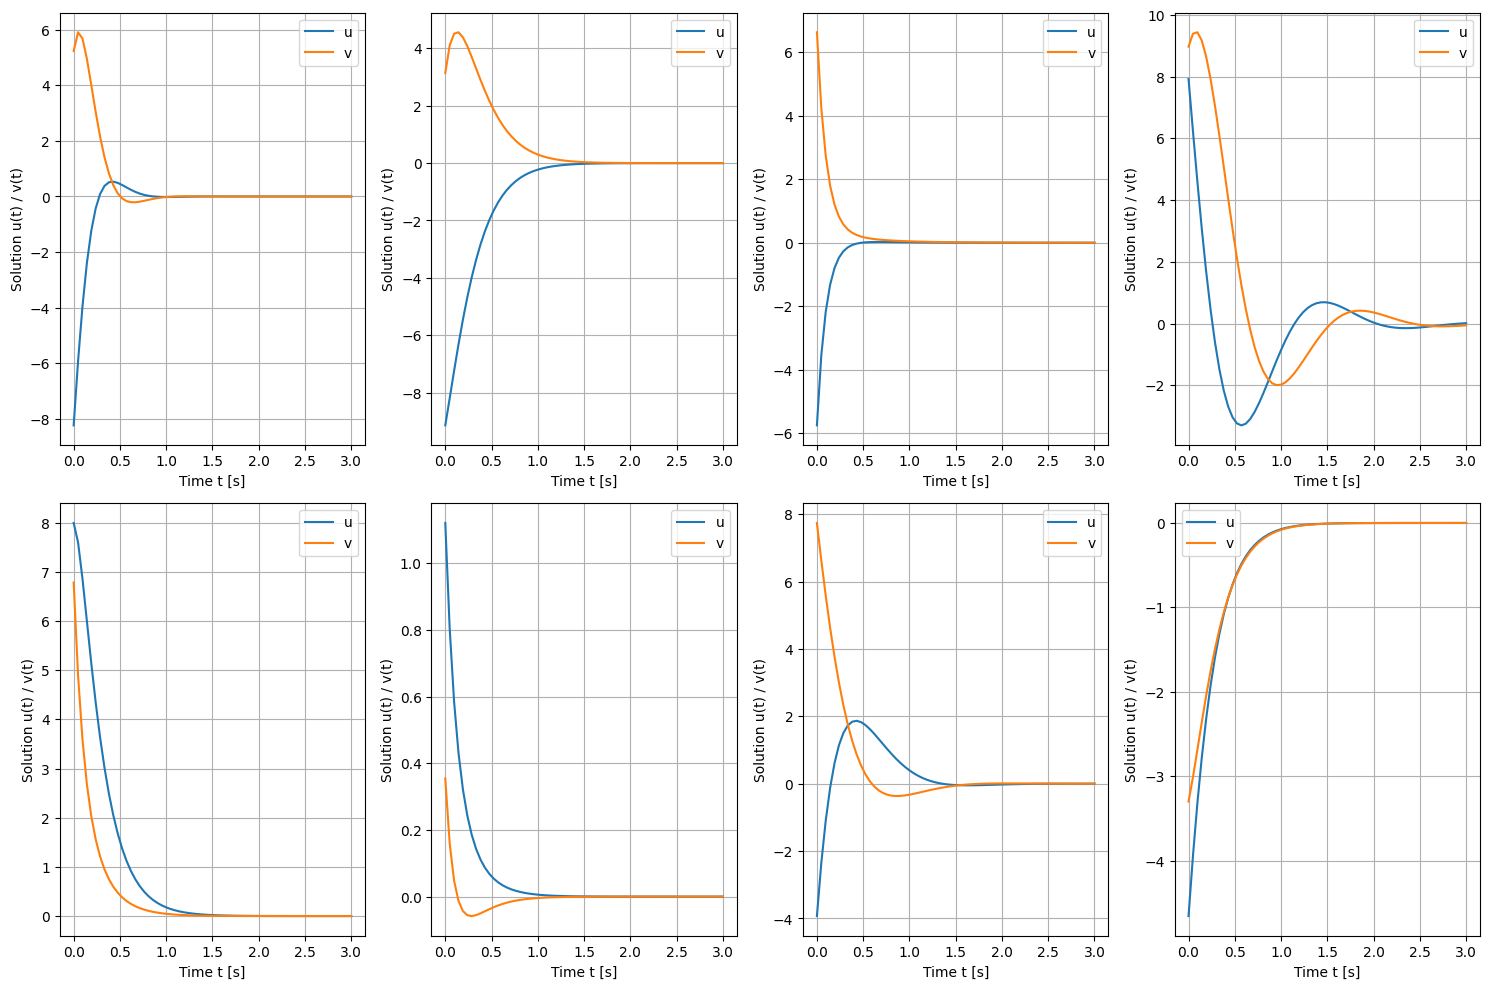

In [9]:
sim_data = model(8)['sim_data']
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
ax = ax.flat

for i, data in enumerate(sim_data):
    ax[i].plot(time_points, data[:, 0], label='u')
    ax[i].plot(time_points, data[:, 1], label='v')
    ax[i].set_xlabel("Time t [s]")
    ax[i].set_ylabel("Solution u(t) / v(t)")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

# BayesFlow architecture

The BayesFlow architecture consists of a summary network and an invertible neural network. The summary network learns summary statistics for each input, such that the summary network output will have the dimensions (batch_size, summary_dim). The invertible neural network is conditioned on the summary statistic of the summary network. For this tutorial, we will use a small LSTM summary network:

In [10]:
class LSTM(tf.keras.Model):
    def __init__(self, summary_dim=64):
        super(LSTM, self).__init__()
        
        self.LSTM = tf.keras.Sequential([
            tf.keras.layers.LSTM(summary_dim, return_sequences=True),
            tf.keras.layers.LSTM(summary_dim, return_sequences=True),
            tf.keras.layers.LSTM(summary_dim)
        ])
    
    def call(self, x, **kwargs):
        out = self.LSTM(x)
        return out

In [11]:
summary_net = LSTM()

2022-08-10 17:44:06.596736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 17:44:06.603043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 17:44:06.603647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 17:44:06.605317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

For the inference network, we will use a small 4-layer cINN:

In [12]:
inference_net = InvertibleNetwork({
    'n_params' : 6,
    'n_coupling_layers' : 8,
})

Finally, we wrap the summary network and inference network into an AmortizedPosterior instance:

In [13]:
amortizer = AmortizedPosterior(inference_net, summary_net, name='linear_ODE_amortizer')

# Preproccessing

Before we feed the simulation data to our BayesFlow amortizer, we want to perform some preprocessing such as normalization, logscale conversion for stability and removing nan/infinite samples.

In [14]:
def preprocessing(forward_dict):
    out_dict = {}
    
    # convert to logscale
    log_data = np.log1p(forward_dict['sim_data']).astype(np.float32)
    
    # normalization
    params = forward_dict['prior_draws'].astype(np.float32)
    norm_params = (params - prior_means) / prior_stds
    
    # remove nan, inf and -inf
    keep_idx = np.all(np.isfinite(log_data), axis=(1, 2))
    if not np.all(keep_idx):
        print('Invalid value encountered...removing from batch')
        
    # add to dict
    out_dict['summary_conditions'] = log_data[keep_idx]
    out_dict['parameters'] = norm_params[keep_idx]
    
    return out_dict

# Training

To train our BayesFlow amortizer, we first have to define a Trainer instance:

In [15]:
trainer = Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=preprocessing,
    learning_rate=PiecewiseConstantDecay([50000, 100000, 150000], [0.001, 0.0001, 0.00001, 0.000001])
)

INFO:root:Performing a consistency check with provided components...
/tmp/ipykernel_23041/3266283559.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  log_data = np.log1p(forward_dict['sim_data']).astype(np.float32)
2022-08-10 17:44:08.656823: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
INFO:root:Done.


Once we initialized the Trainer instance and run a consistency check on a test batch, we can print the number of trainable and non-trainable parameters in our BayesFlow model:

In [16]:
amortizer.summary()

Model: "linear_ODE_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 278816    
 bleNetwork)                                                     
                                                                 
 lstm (LSTM)                 multiple                  83200     
                                                                 
Total params: 362,016
Trainable params: 361,920
Non-trainable params: 96
_________________________________________________________________


Now, we can train our BayesFlow model online:

In [17]:
losses = trainer.train_online(epochs=200, iterations_per_epoch=1000, batch_size=32)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_23041/3266283559.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  log_data = np.log1p(forward_dict['sim_data']).astype(np.float32)


Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 31:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 32:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 33:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 34:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 35:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 36:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 37:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 38:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 39:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 40:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 41:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 42:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 43:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 44:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 45:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 46:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 47:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 48:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 49:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 51:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 52:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 53:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 54:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 55:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 56:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 57:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 58:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 59:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 60:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 61:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 62:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 63:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 64:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 65:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 66:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 67:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 68:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 69:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 70:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 71:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 72:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 73:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 74:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 75:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 76:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 77:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 78:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 79:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 80:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 81:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 82:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 83:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 84:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 85:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 86:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 87:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 88:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 89:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 90:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 91:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 92:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 93:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 94:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 95:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 96:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 97:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 98:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 99:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 100:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 101:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 102:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 103:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 104:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 105:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 106:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 107:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 108:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 109:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 110:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 111:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 112:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 113:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 114:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 115:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 116:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 117:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 118:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 119:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 120:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 121:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 122:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 123:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 124:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 125:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 126:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 127:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 128:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 129:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 130:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 131:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 132:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 133:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 134:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 135:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 136:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 137:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 138:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 139:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 140:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 141:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 142:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 143:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 144:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 145:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 146:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 147:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 148:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 149:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 150:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 151:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 152:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 153:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 154:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 155:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 156:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 157:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 158:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 159:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 160:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 161:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 162:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 163:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 164:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 165:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 166:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 167:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 168:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 169:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 170:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 171:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 172:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 173:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 174:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 175:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 176:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 177:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 178:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 179:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 180:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 181:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 182:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 183:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 184:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 185:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 186:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 187:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 188:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 189:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 190:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 191:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 192:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 193:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 194:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 195:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 196:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 197:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 198:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 199:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 200:   0%|          | 0/1000 [00:00<?, ?it/s]

We can visualize the training loss to inspect, if the training has converge.

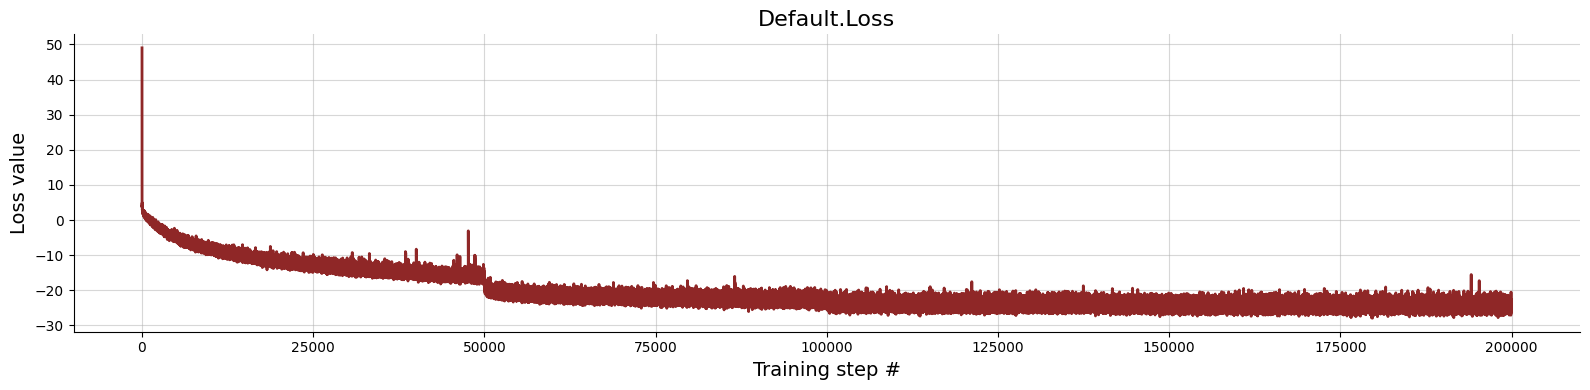

In [18]:
fig = diag.plot_losses(losses)

# Validating the results

After training BayesFlow, we want to validate the results. One first step is to inspect the latent space $z$, which by training we enforce to be Gaussian using Kullback-Leibler (KL) loss.  

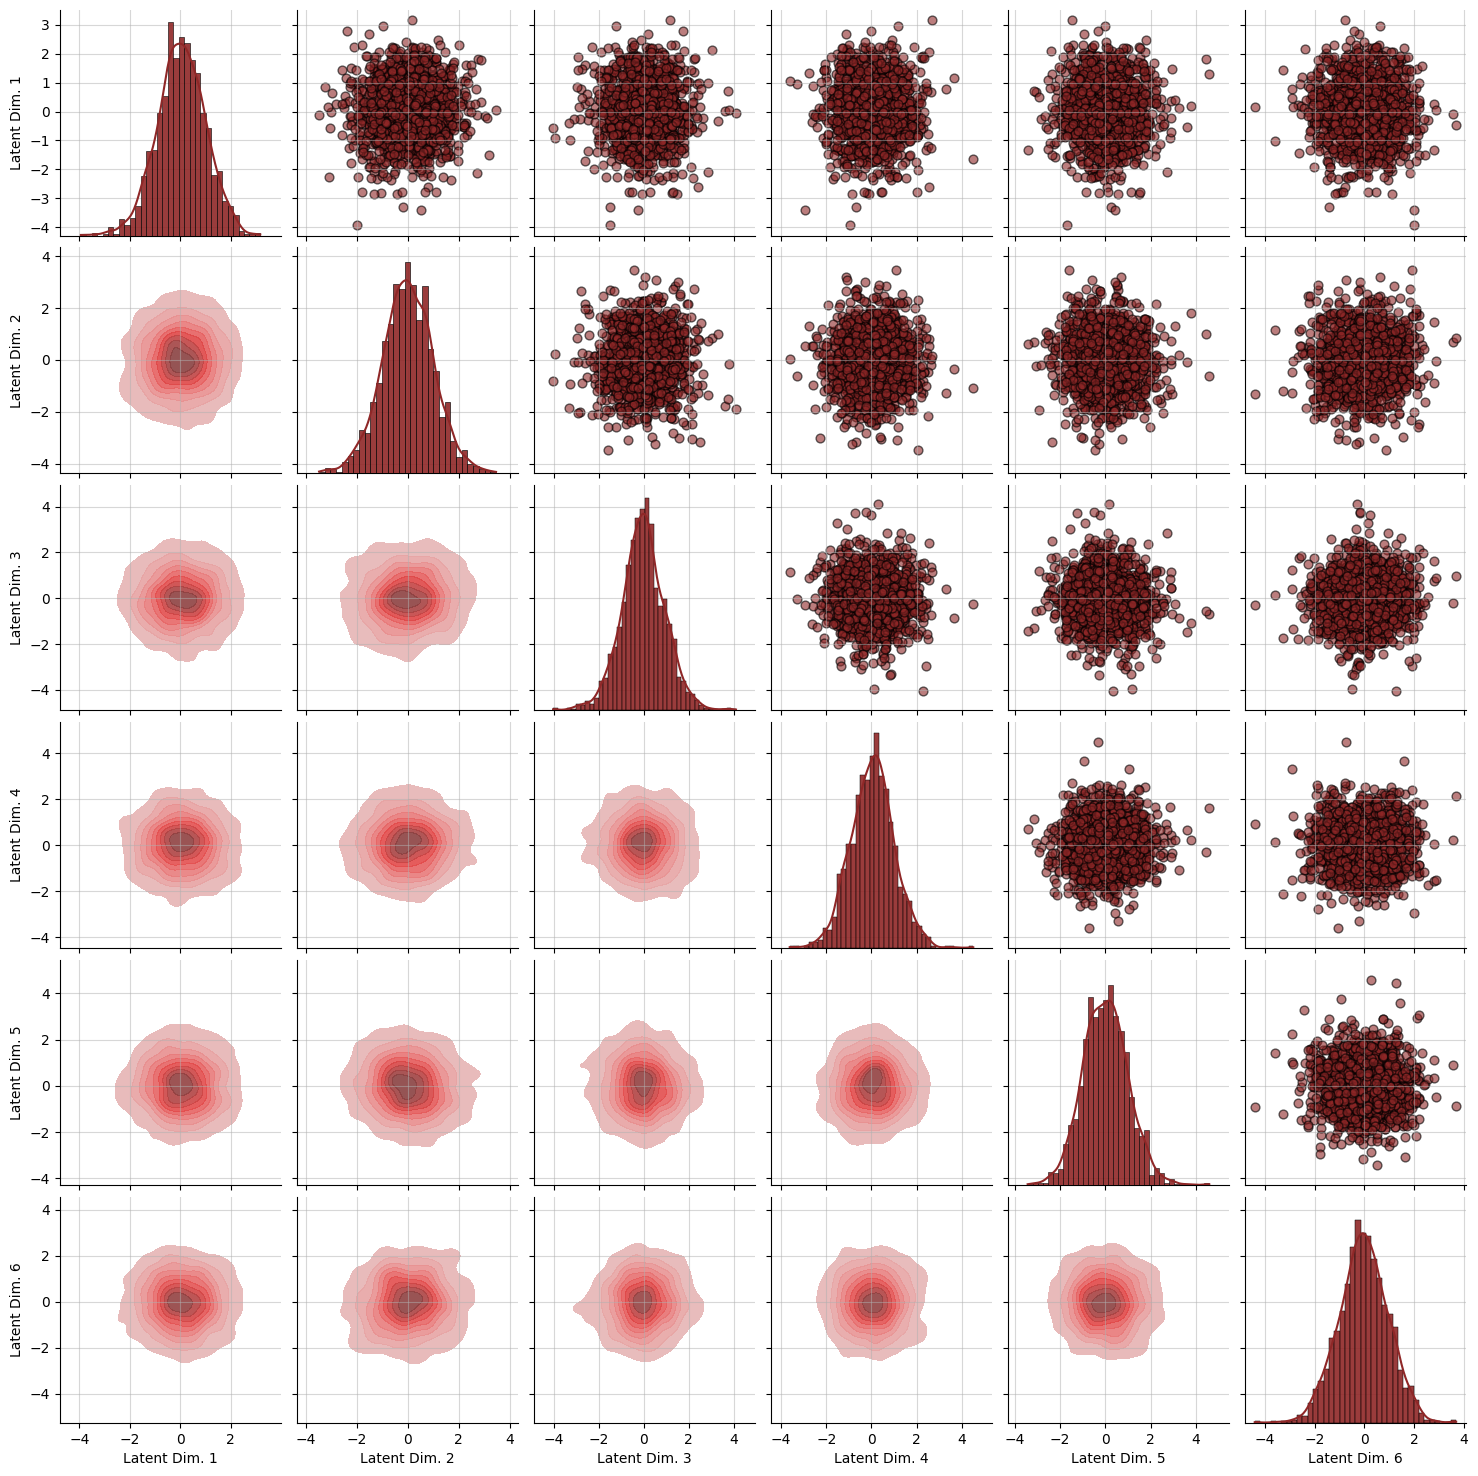

In [19]:
fig = trainer.diagnose_latent2d()

Next we can test the simulation-based calibration (SBC) as proposed by [Talts et al. (2020)](https://arxiv.org/pdf/1804.06788.pdf):

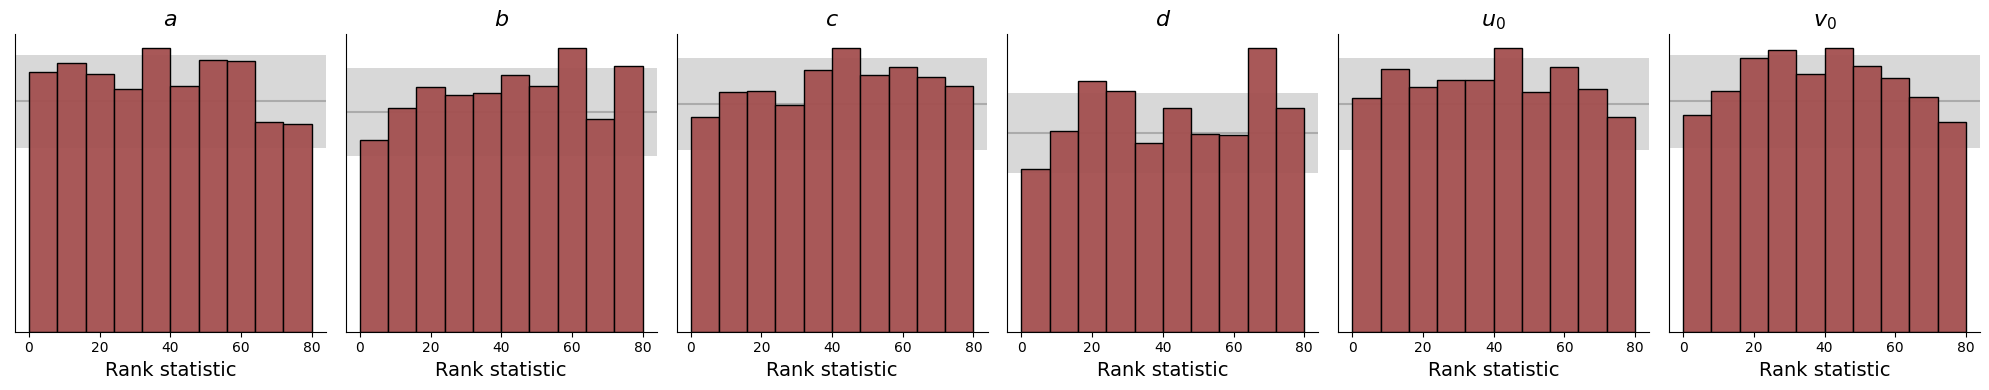

In [20]:
fig = trainer.diagnose_sbc_histograms()

Alternatively, we can also inspect the simulation-based calibration through empirical cumulative distribution functions (ECDF) instead of histograms as proposed by [Teemu Säilynoja et al. (2021)](https://arxiv.org/pdf/2103.10522.pdf):

/tmp/ipykernel_23041/3266283559.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  log_data = np.log1p(forward_dict['sim_data']).astype(np.float32)


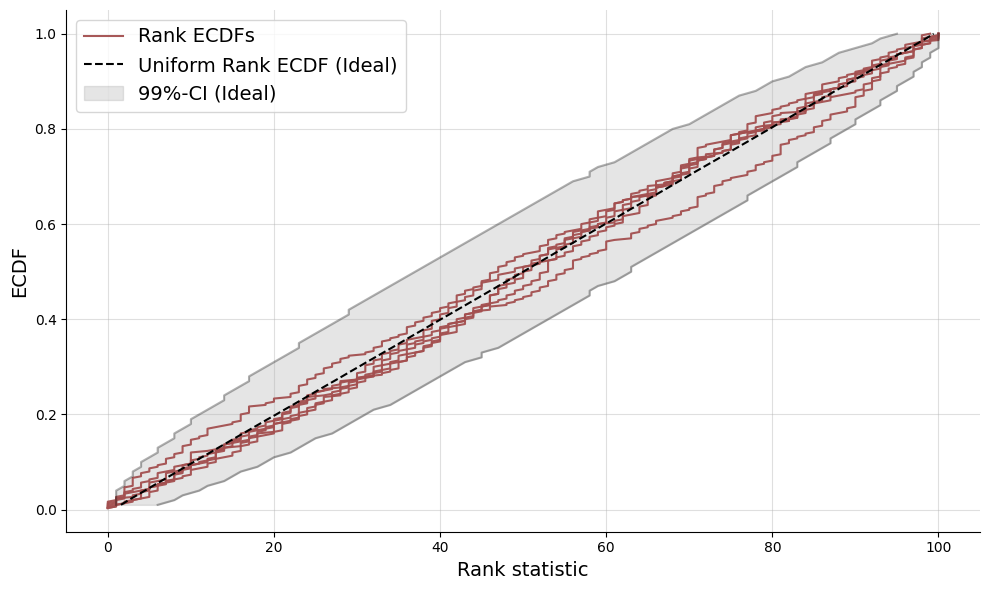

In [21]:
valid_sim_data_raw = model(batch_size=300)
valid_sim_data = trainer.configurator(valid_sim_data_raw)
posterior_samples = amortizer.sample(valid_sim_data, n_samples=100)
fig = diag.plot_sbc_ecdf(posterior_samples, valid_sim_data['parameters'])

During inference, BayesFlow will provide us with a posterior distribution for every hidden parameter. To get a prediction from BayesFlow, we will simply take the mean value of the posterior. For validation, we can plot the mean prediction value against the ground truth and compute the R Squared for our model. In the ideal case, all predicted values should lie on the diagonal line. 

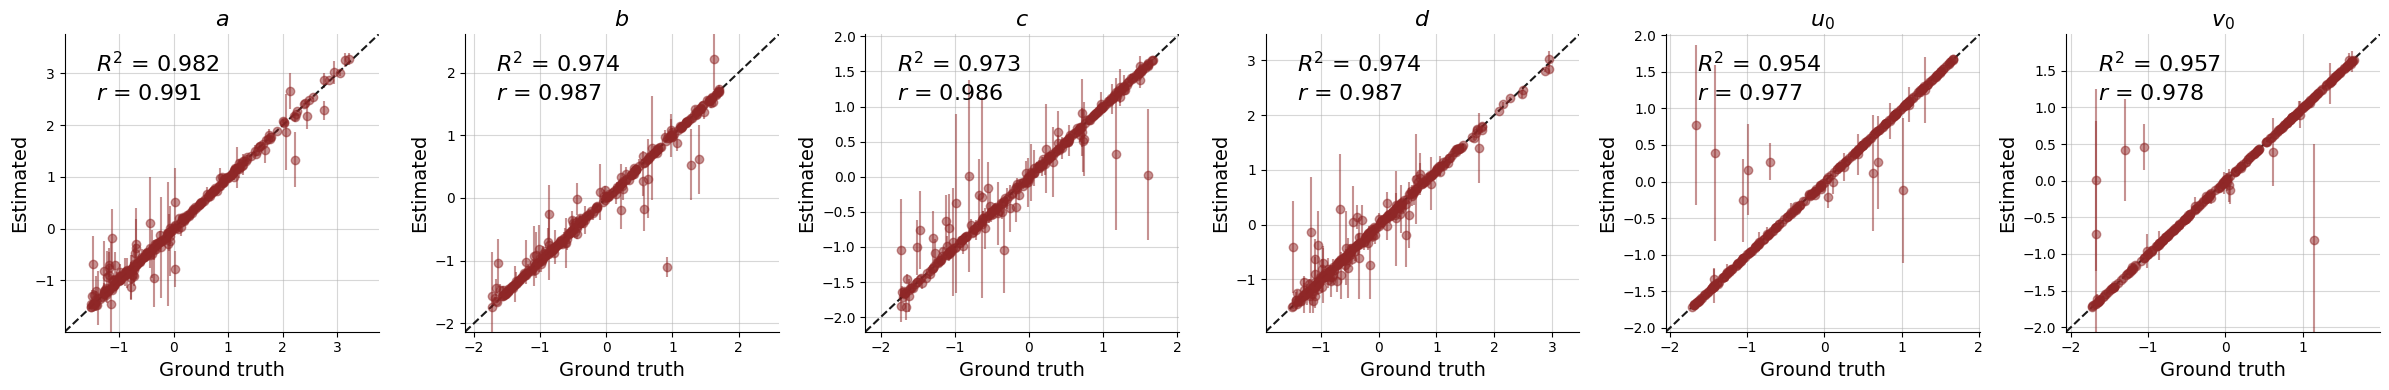

In [22]:
fig = diag.plot_recovery(posterior_samples, valid_sim_data['parameters'], param_names=prior.param_names)

We can also visualize the bivariate posteriors between different hidden parameters and compare them to the priors:

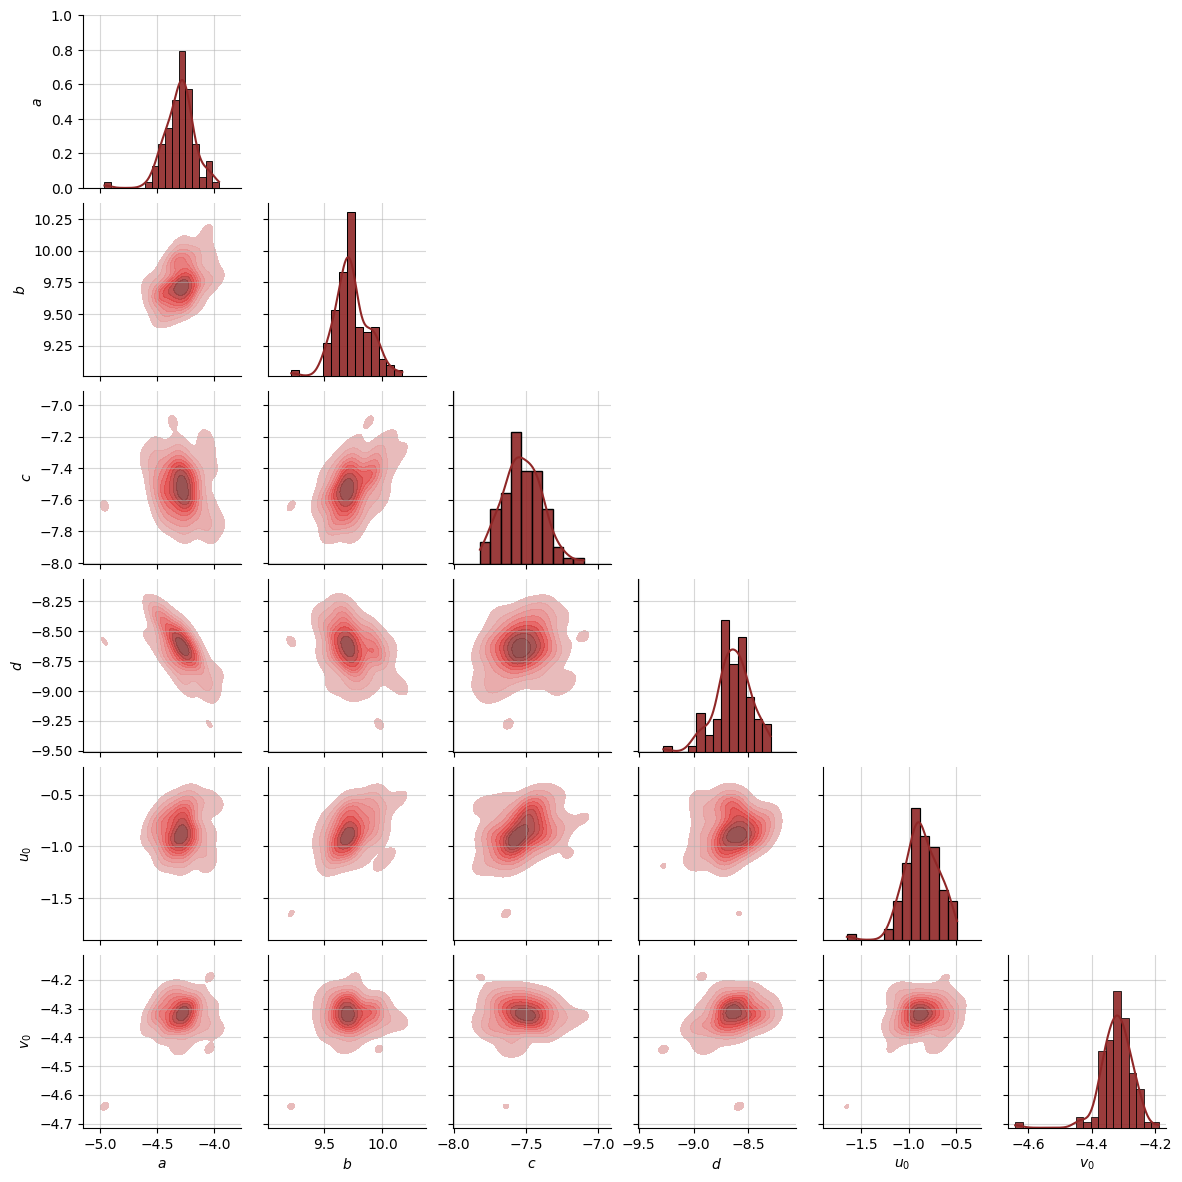

In [23]:
posterior_samples_unnorm = prior_means + posterior_samples * prior_stds
fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], param_names=prior.param_names)

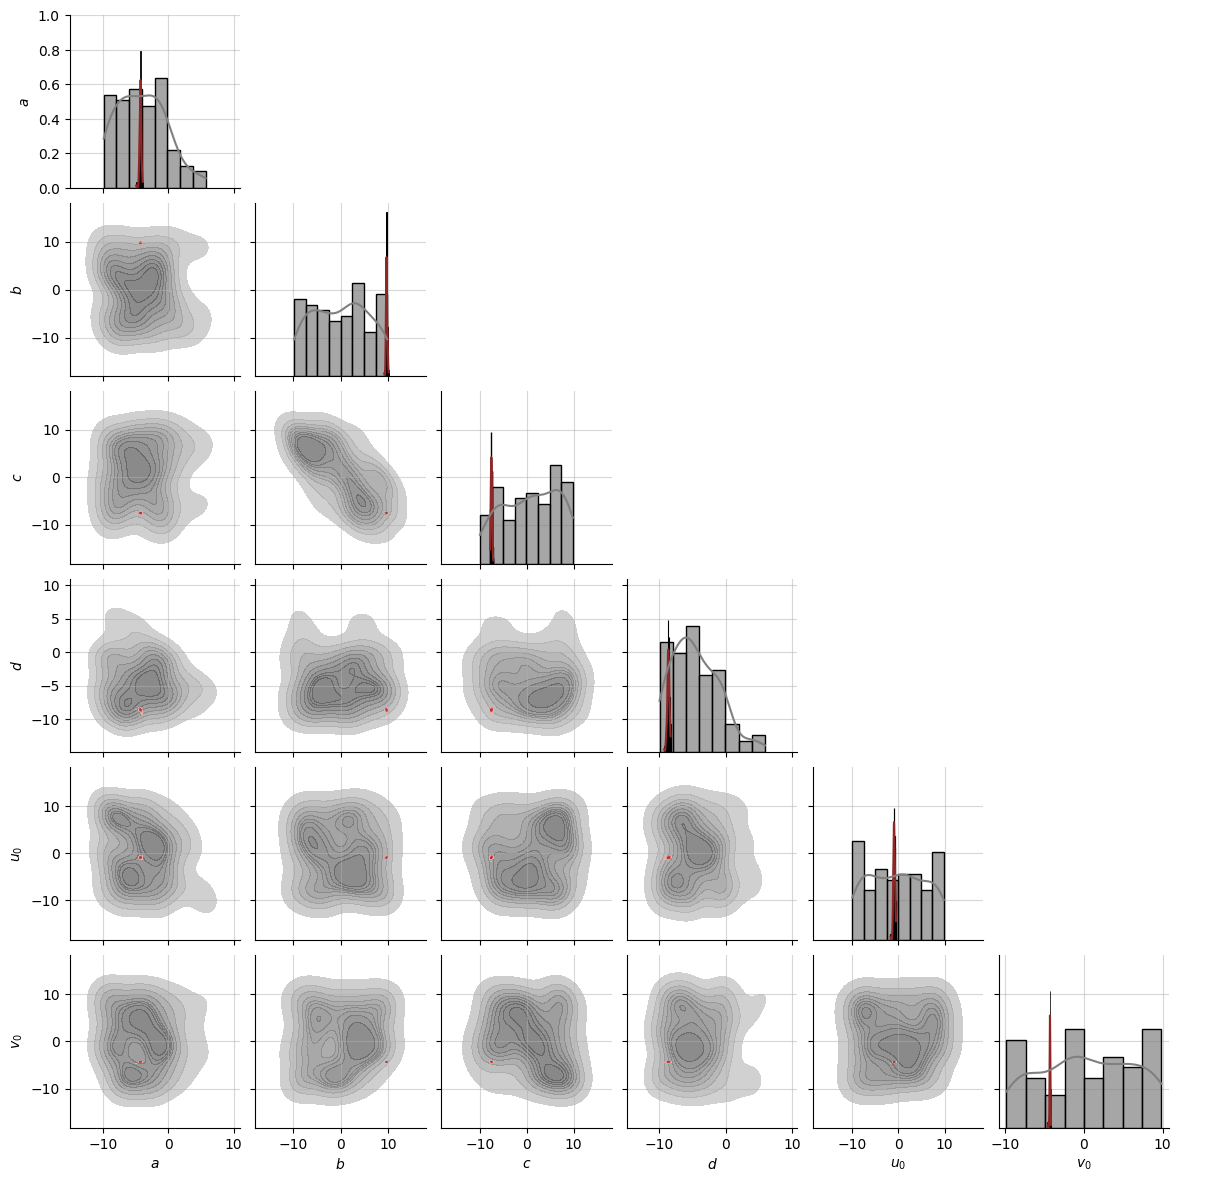

In [24]:
fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], prior=prior)

The last check we want to perform is the Re-simulation. Given a set of linear ODE solutions of $u(t)$ and $v(t)$, we predict the posterior of $a$, $b$, $c$, $d$, $u_0$ and $v_0$. All parameter posterior samples will then be passed to the simulator to re-simulate $\hat{u}_i(t)$ and $\hat{v}_i(t)$. Finally, we compute the median and quantile between all $\hat{u}_i(t)$ and $\hat{v}_i(t)$ and compare to the ground truth soluations $u(t)$ and $v(t)$:

/tmp/ipykernel_23041/36248105.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  resim_u[i, :] = re_sim[:, 0]
/tmp/ipykernel_23041/36248105.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  resim_v[i, :] = re_sim[:, 1]
/home/leo/.local/share/virtualenvs/BayesFlow-sDCF3KYj/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


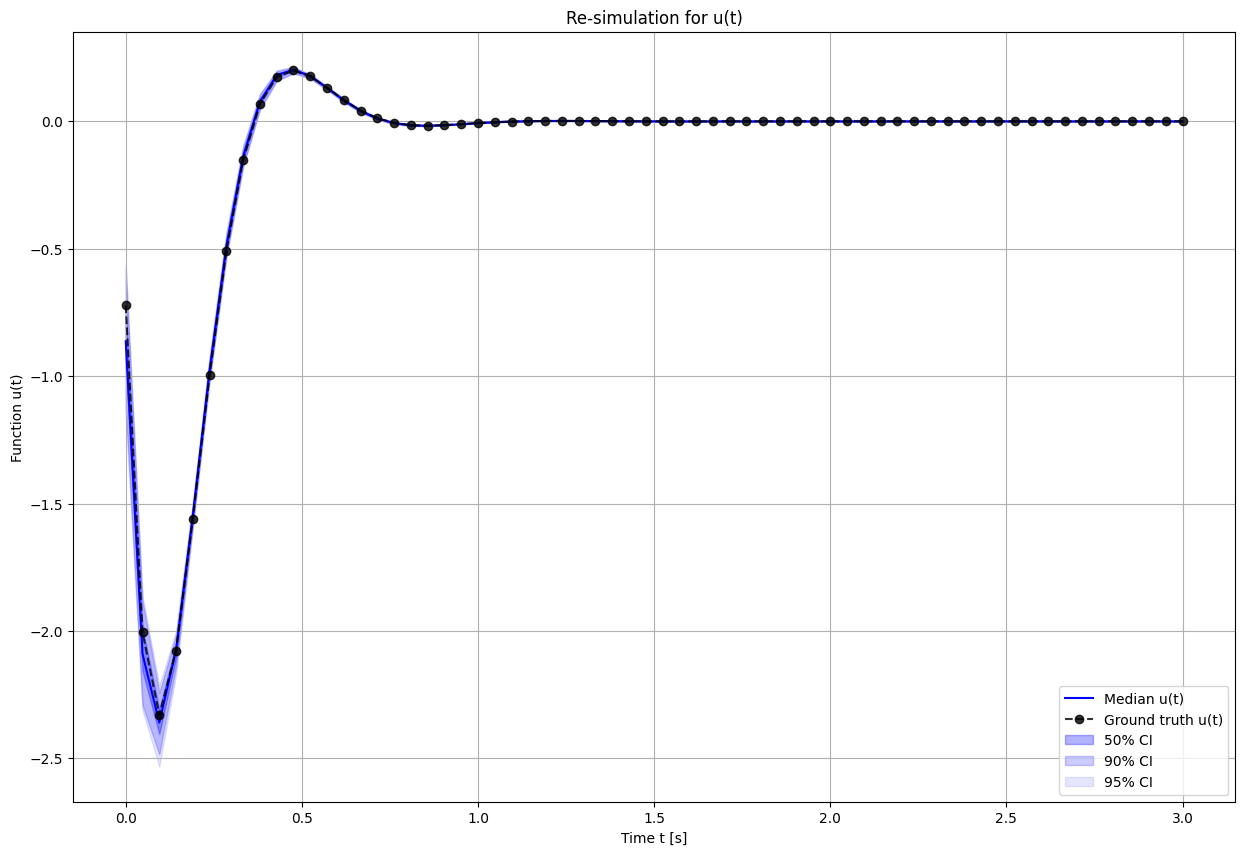

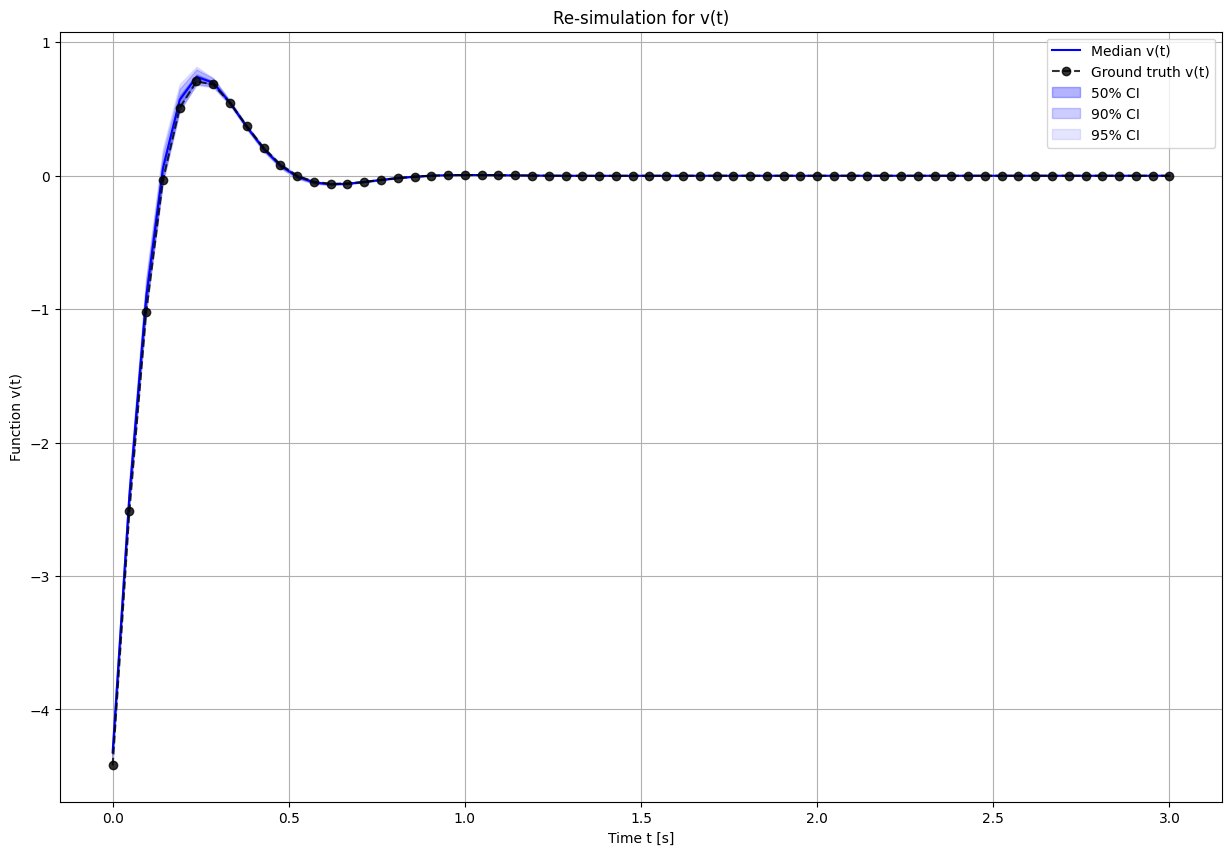

In [25]:
# re-simulation
resim_u = np.empty((posterior_samples_unnorm[0].shape[0], len(time_points)), dtype=np.float32)
resim_v = np.empty((posterior_samples_unnorm[0].shape[0], len(time_points)), dtype=np.float32)

for i in range(posterior_samples_unnorm[0].shape[0]):
    re_sim = linear_ode_solver(posterior_samples_unnorm[0, i], time_points)
    resim_u[i, :] = re_sim[:, 0]
    resim_v[i, :] = re_sim[:, 1]

# compute quantiles
u_qt_50 = np.quantile(resim_u, q=[0.25, 0.75], axis=0)
u_qt_90 = np.quantile(resim_u, q=[0.05, 0.95], axis=0)
u_qt_95 = np.quantile(resim_u, q=[0.025, 0.975], axis=0)
v_qt_50 = np.quantile(resim_v, q=[0.25, 0.75], axis=0)
v_qt_90 = np.quantile(resim_v, q=[0.05, 0.95], axis=0)
v_qt_95 = np.quantile(resim_v, q=[0.025, 0.975], axis=0)
    
# plot u
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(time_points, np.median(resim_u, axis=0), label='Median u(t)', color='b')
ax.plot(time_points, valid_sim_data_raw['sim_data'][0, :, 0], marker='o', label='Ground truth u(t)', color='k', linestyle='--', alpha=0.8)
ax.fill_between(time_points, u_qt_50[0], u_qt_50[1], color='b', alpha=0.3, label='50% CI')
ax.fill_between(time_points, u_qt_90[0], u_qt_90[1], color='b', alpha=0.2, label='90% CI')
ax.fill_between(time_points, u_qt_95[0], u_qt_95[1], color='b', alpha=0.1, label='95% CI')
ax.grid(True)
ax.set_title("Re-simulation for u(t)")
ax.set_xlabel("Time t [s]")
ax.set_ylabel("Function u(t)")
ax.legend()
plt.show()

# plot v
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(time_points, np.median(resim_v, axis=0), label='Median v(t)', color='b')
ax.plot(time_points, valid_sim_data_raw['sim_data'][0, :, 1], marker='o', label='Ground truth v(t)', color='k', linestyle='--', alpha=0.8)
ax.fill_between(time_points, v_qt_50[0], v_qt_50[1], color='b', alpha=0.3, label='50% CI')
ax.fill_between(time_points, v_qt_90[0], v_qt_90[1], color='b', alpha=0.2, label='90% CI')
ax.fill_between(time_points, v_qt_95[0], v_qt_95[1], color='b', alpha=0.1, label='95% CI')
ax.grid(True)
ax.set_title("Re-simulation for v(t)")
ax.set_xlabel("Time t [s]")
ax.set_ylabel("Function v(t)")
ax.legend()
plt.show()

In [26]:
%%javascript
IPython.notebook.save_notebook()